# 9.  NDCG Scores Analysis

In this notebook, we will review the collected NDCG scores in order to understand how the 3 ranking methods, i.e. *i) Average*, *ii) Discounted Reward*, and *iii) Discounted Reward with Adjustment by Opposite Query*, are performed. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import altair as alt

from PIL import Image
import session_info

In [2]:
df_ndcg = pd.read_csv('../resources/eval/ndcg.csv')

## Calculate Summary Statistics

In [3]:
df_ndcg.groupby(by=['Ranking Method']).agg(['mean', 'std']).reset_index()

Ranking Method   NDCG@10              NDCG@5            \
                                          mean       std      mean       std   
0                            Average  0.934942  0.029665  0.847391  0.071619   
1             Discounted Reward Only  0.938667  0.034658  0.861454  0.064198   
2  Discounted Reward with Adjustment  0.941133  0.035437  0.861850  0.078226   

     NDCG@3            
       mean       std  
0  0.819158  0.083496  
1  0.836880  0.092629  
2  0.837094  0.103234

## Create Visualizations on Overall Level

In [4]:
# preppare data for showing the Top Ranking Method 
df_ndcg_avg = df_ndcg.groupby(by=['Query ID', 'Ranking Method']).mean().reset_index()
df_ndcg_avg_melt = df_ndcg_avg.melt(id_vars=['Query ID', 'Ranking Method'])
df_ndcg_avg_melt = df_ndcg_avg_melt.sort_values(['Query ID', 'value'], ascending=[True, False])
df_ndcg_avg_melt = df_ndcg_avg_melt.groupby(by=['Query ID', 'variable']).first().reset_index()
df_ndcg_avg_melt.head(5)

,Query ID,variable,Ranking Method,value
0,Q1,NDCG@10,Discounted Reward Only,0.951410
1,Q1,NDCG@3,Discounted Reward Only,0.880234
2,Q1,NDCG@5,Discounted Reward Only,0.852802
3,Q2,NDCG@10,Average,0.949599
4,Q2,NDCG@3,Average,0.851194


In [5]:
# prepare data for bar chart with error bars
df_ndcg_melt = df_ndcg.melt(id_vars=['Query ID', 'Ranking Method', 'User ID'])
df_ndcg_melt.head(5)


,Query ID,Ranking Method,User ID,variable,value
0,Q1,Average,U1,NDCG@10,0.917250
1,Q1,Discounted Reward Only,U1,NDCG@10,0.959709
2,Q1,Discounted Reward with Adjustment,U1,NDCG@10,0.929303
3,Q2,Average,U1,NDCG@10,0.981928
4,Q2,Discounted Reward Only,U1,NDCG@10,0.909765


In [6]:
domain = ['Average', 'Discounted Reward Only', 'Discounted Reward with Adjustment']
range_ = ['#20a4d0', '#f4b036', '#9cc989']

rect_chart = alt.Chart(data=df_ndcg_avg_melt).mark_rect(opacity=0.7, stroke='black', strokeWidth=1).encode(
    y=alt.Y('Query ID:O'),
    x=alt.X('variable:N', title='NDCG', sort=['NDCG@3', 'NDCG@5', 'NDCG@10']),
    color=alt.Color('Ranking Method:N').scale(domain=domain, range=range_)
).properties(
    width=100,
    height=300,
    title='Top Ranking Method per Query'
)

bar_chart = alt.Chart(data=df_ndcg_melt).mark_bar(opacity=0.9, clip=True).encode(
    x=alt.X('variable:N', title='NDCG', sort=['NDCG@3', 'NDCG@5', 'NDCG@10']),
    y=alt.Y('mean(value):Q').scale(domain=(0.5,1)),
    color=alt.Color('Ranking Method:N').scale(domain=domain, range=range_),
    xOffset='Ranking Method:N',
)

error_bars = alt.Chart(data=df_ndcg_melt).mark_errorbar(extent='ci').encode(
    x=alt.X('variable:N', title='NDCG', sort=['NDCG@3', 'NDCG@5', 'NDCG@10']),
    y=alt.Y('value:Q').scale(domain=(0.5,1)),
    xOffset='Ranking Method:N'
)

bar_chart_with_error = (bar_chart + error_bars).properties(
    width=400,
    height=300,
    title='Mean NDCG across Ranking Methods'
)

eval_analysis_chart = alt.hconcat(bar_chart_with_error, rect_chart).configure_legend(labelLimit= 0)

eval_analysis_chart


alt.HConcatChart(...)

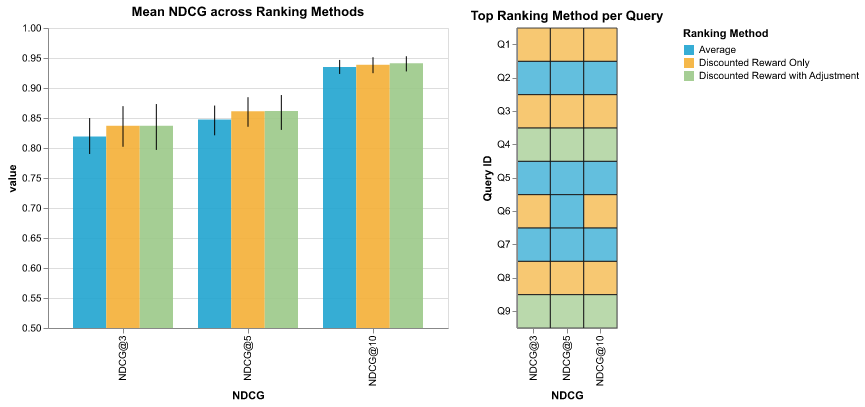

In [7]:
# Uncomment below line to save a new version of the vis
#eval_analysis_chart.save('../resources/img/eval_analysis_chart.png')
Image.open('../resources/img/eval_analysis_chart.png')

Generally the *Method 2) Discounted Reward Only* and *Method 3) Discounted Reward with Adjustment by Opposite Query* performed better than the *Method 1) Average*. However, *Method 2* is just a tiny bit better than *Method 3* in NDCG@5 and NDCG@10. The 95% confidence intervals are very similar for all three methods within the same NDCG group. On the other hand, *Method 1* had a 37% (10/27) chance of getting the best results while for *Method 2* and *Method 3* it was 41% (11/27) and 22% (6/27) respectively.


Overall, while *Method 3* had the highest mean NDCG scores, in practice *Method 2* had almost a double chance to outperform *Method 3*. It means *Method 3* performed much better in some cases only but not all. 


## Create Visualization on Query Level

In [8]:
domain = ['Average', 'Discounted Reward Only', 'Discounted Reward with Adjustment']
range_ = ['#20a4d0', '#f4b036', '#9cc989']

chart_3 = alt.Chart(data=df_ndcg_avg).mark_bar(opacity=1, clip=True).encode(
    y=alt.Y('Query ID:O'),
    x=alt.X('NDCG@3:Q').scale(domain=(0.5,1)),
    color=alt.Color('Ranking Method:N').scale(domain=domain, range=range_),
    yOffset='Ranking Method:N',
    text=alt.Text('NDCG@3:Q', format=',.2f')
).properties(
    width=180,
    height=500,
)

chart_3_text = chart_3 + chart_3.mark_text(align='left', dx=2)

chart_5 = alt.Chart(data=df_ndcg_avg).mark_bar(opacity=1, clip=True).encode(
    y=alt.Y('Query ID:O', title=''),
    x=alt.X('NDCG@5:Q').scale(domain=(0.5,1)),
    color=alt.Color('Ranking Method:N').scale(domain=domain, range=range_),
    yOffset='Ranking Method:N',
    text=alt.Text('NDCG@5:Q', format=',.2f')
).properties(
    width=180,
    height=500,
)

chart_5_text = chart_5 + chart_5.mark_text(align='left', dx=2)

chart_10 = alt.Chart(data=df_ndcg_avg).mark_bar(opacity=1, clip=True).encode(
    y=alt.Y('Query ID:O', title=''),
    x=alt.X('NDCG@10:Q').scale(domain=(0.5,1)),
    color=alt.Color('Ranking Method:N').scale(domain=domain, range=range_),
    yOffset='Ranking Method:N',
    text=alt.Text('NDCG@10:Q', format=',.2f')
).properties(
    width=180,
    height=500
)

chart_10_text = chart_10 + chart_10.mark_text(align='left', dx=2)

ndcg_summary_chart = alt.hconcat(chart_3_text, chart_5_text, chart_10_text, title=alt.Title(text='NDCG Score for all Queries', anchor='middle')).configure_legend(labelLimit= 0)
ndcg_summary_chart

alt.HConcatChart(...)

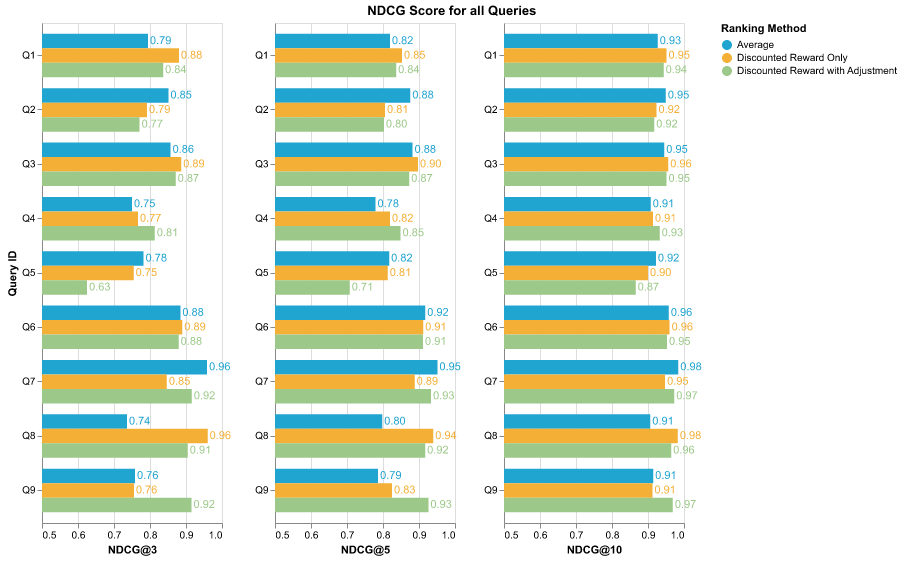

In [9]:
# Uncomment below line to save a new version of the vis
#ndcg_summary_chart.save('../resources/img/ndcg_summary_chart.png')
Image.open('../resources/img/ndcg_summary_chart.png')

### List of libraries used

In [10]:
session_info.show()